In [1]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

# Custom imports
from helper_functions import evaluate_clf, label_encode
from StylometryPrep import StylometryFeatureExtractor

In [2]:
DATA_PATH = "lai-data/political_leaning.csv"
FEATURE = "political_leaning"

In [3]:
# df_politics = pd.read_csv(DATA_PATH).iloc[:3000] # remove iloc to test full dataset
df_politics = pd.read_csv(DATA_PATH)
df, le = label_encode(df_politics, FEATURE)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_politics['post'], df_politics[FEATURE],test_size= 0.3)

In [5]:
nlp = spacy.load("en_core_web_sm")

## 1. BoW classification

In [6]:
clf = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('svc', LinearSVC())
])

clf.fit(X_train, y_train)

/home/egor/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/egor/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('svc', LinearSVC())])

In [7]:
evaluate_clf(clf, X_test, y_test, classes=le.classes_)

              precision    recall  f1-score   support

           0       0.73      0.74      0.74      7524
           1       0.67      0.65      0.66      4360
           2       0.70      0.71      0.70      5286

    accuracy                           0.71     17170
   macro avg       0.70      0.70      0.70     17170
weighted avg       0.71      0.71      0.71     17170



## 2. Stylometry + BoW

In [8]:
# Create a pipeline
clf_stylometry = Pipeline([
    ('features', FeatureUnion([
        ('text', CountVectorizer(stop_words='english')),  # You can include other text-based features here
        ('stylometry', StylometryFeatureExtractor())
    ])),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LinearSVC())
])

# Fit the model
clf_stylometry.fit(X_train, y_train)

/home/egor/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/egor/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text',
                                                 CountVectorizer(stop_words='english')),
                                                ('stylometry',
                                                 StylometryFeatureExtractor())])),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf', LinearSVC())])

              precision    recall  f1-score   support

           0       0.72      0.83      0.77      7524
           1       0.76      0.61      0.68      4360
           2       0.76      0.73      0.74      5286

    accuracy                           0.74     17170
   macro avg       0.75      0.72      0.73     17170
weighted avg       0.74      0.74      0.74     17170



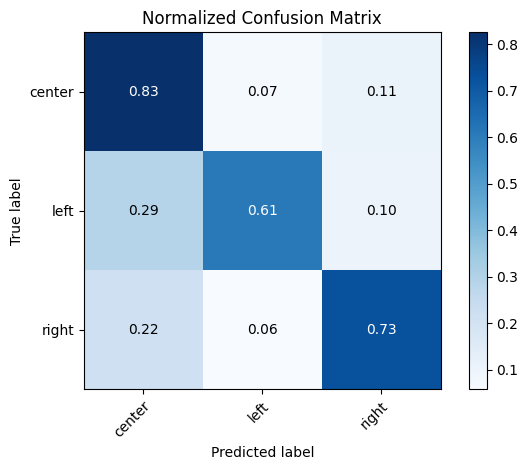

In [9]:
evaluate_clf(clf_stylometry, X_test, y_test, classes=le.classes_)

## 3. Pure Stylometry

pretty useless lol

In [10]:
# Create a pipeline
clf_pure_stylometry = Pipeline([
    ('features', FeatureUnion([
        ('stylometry', StylometryFeatureExtractor())
    ])),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LinearSVC())
])

clf_pure_stylometry.fit(X_train, y_train)

/home/egor/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/egor/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('stylometry',
                                                 StylometryFeatureExtractor())])),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf', LinearSVC())])

              precision    recall  f1-score   support

           0       0.44      0.74      0.56      7524
           1       0.28      0.01      0.01      4360
           2       0.36      0.31      0.33      5286

    accuracy                           0.42     17170
   macro avg       0.36      0.35      0.30     17170
weighted avg       0.37      0.42      0.35     17170



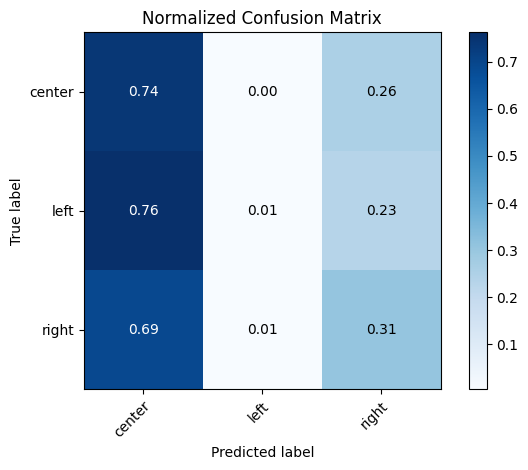

In [11]:
evaluate_clf(clf_pure_stylometry, X_test, y_test, classes=le.classes_)

In [12]:
# Alex Jones test
sentence = "I don't like them putting chemicals in the water that turn the frigging frogs gay."

print(le.classes_[clf.predict([sentence])[0]])
print(le.classes_[clf_stylometry.predict([sentence])[0]])

center
center


## 4. RandomForest
### 4.1 BoW + Stylometry

              precision    recall  f1-score   support

           0       0.51      0.95      0.67      7524
           1       0.87      0.21      0.34      4360
           2       0.79      0.33      0.47      5286

    accuracy                           0.57     17170
   macro avg       0.72      0.50      0.49     17170
weighted avg       0.69      0.57      0.52     17170



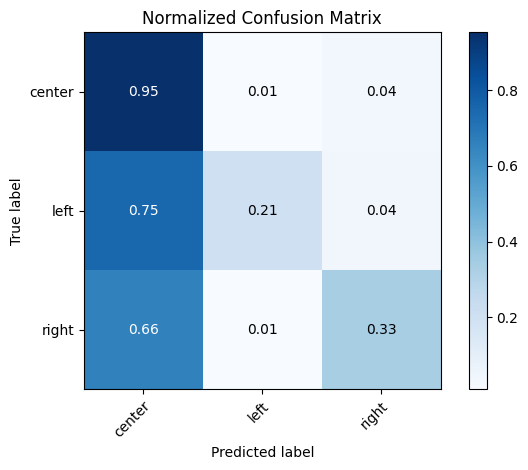

In [13]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

# Import your StylometryFeatureExtractor class here

# Define the pipeline for Random Forest
clf_random_forest = Pipeline([
    ('features', FeatureUnion([
        ('text', CountVectorizer(stop_words='english')),  # You can include other text-based features here
        ('stylometry', StylometryFeatureExtractor())
    ])),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', RandomForestClassifier())
])
clf_random_forest.fit(X_train, y_train)
evaluate_clf(clf_random_forest, X_test, y_test, classes=le.classes_)

### 4.3 BoW

              precision    recall  f1-score   support

           0       0.51      0.95      0.66      7524
           1       0.85      0.20      0.32      4360
           2       0.78      0.31      0.45      5286

    accuracy                           0.56     17170
   macro avg       0.71      0.49      0.48     17170
weighted avg       0.68      0.56      0.51     17170



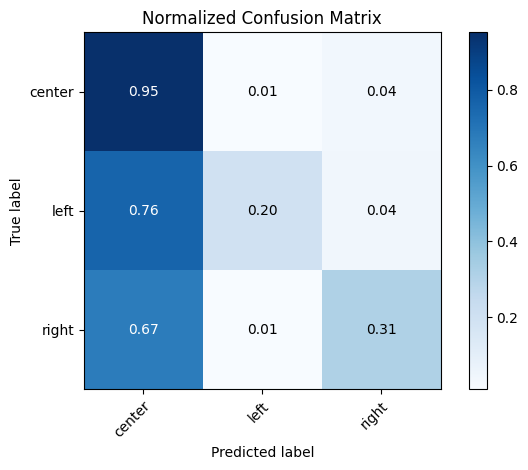

In [14]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

# Import your StylometryFeatureExtractor class here

# Define the pipeline for Random Forest
clf_random_forest = Pipeline([
    ('features', FeatureUnion([
        ('text', CountVectorizer(stop_words='english')),  # You can include other text-based features here
    ])),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', RandomForestClassifier())
])
clf_random_forest.fit(X_train, y_train)
evaluate_clf(clf_random_forest, X_test, y_test, classes=le.classes_)

## 5 XGBoost
### 5.1 BoW + Stylometry

              precision    recall  f1-score   support

           0       0.63      0.84      0.72      7524
           1       0.77      0.49      0.60      4360
           2       0.72      0.59      0.65      5286

    accuracy                           0.68     17170
   macro avg       0.71      0.64      0.66     17170
weighted avg       0.70      0.68      0.67     17170



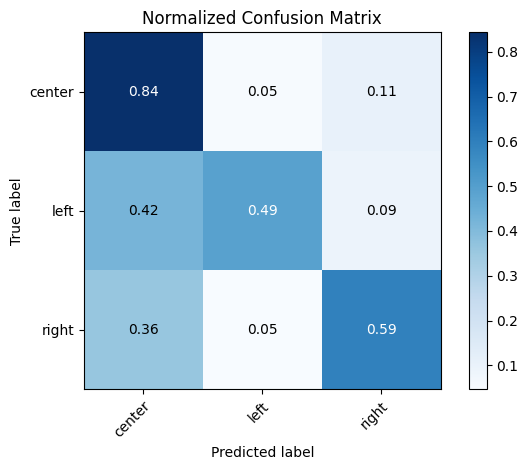

In [15]:
# Define the pipeline for XGBoost
clf_xgboost = Pipeline([
    ('features', FeatureUnion([
        ('text', CountVectorizer(stop_words='english')),  # You can include other text-based features here
        ('stylometry', StylometryFeatureExtractor())
    ])),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', XGBClassifier())
])
clf_xgboost.fit(X_train, y_train)
evaluate_clf(clf_xgboost, X_test, y_test, classes=le.classes_)

### 5.2 BoW

              precision    recall  f1-score   support

           0       0.62      0.85      0.72      7524
           1       0.78      0.46      0.58      4360
           2       0.71      0.58      0.64      5286

    accuracy                           0.67     17170
   macro avg       0.70      0.63      0.64     17170
weighted avg       0.69      0.67      0.66     17170



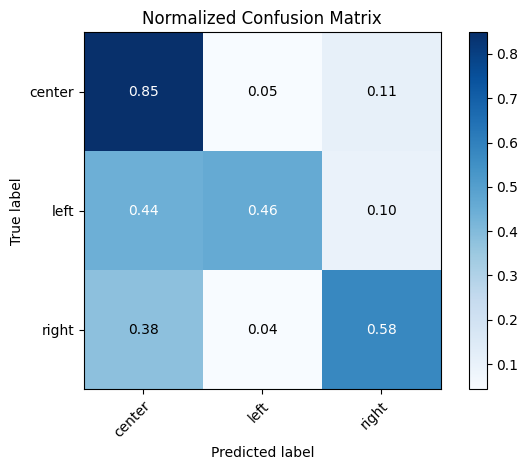

In [16]:
# Define the pipeline for XGBoost
clf_xgboost = Pipeline([
    ('features', FeatureUnion([
        ('text', CountVectorizer(stop_words='english')),  # You can include other text-based features here
    ])),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', XGBClassifier())
])
clf_xgboost.fit(X_train, y_train)
evaluate_clf(clf_xgboost, X_test, y_test, classes=le.classes_)